# CIFAR-10 Outlier Detection
![demo](./demo.png)

In this example, we will deploy an image classification model along with an outlier detector trained on the same dataset. For in depth details on creating an outlier detection model for your own dataset, check out the [Alibi Detect](https://github.com/SeldonIO/alibi-detect) project and its associated [documentation](https://docs.seldon.io/projects/alibi-detect/en/latest/). They also provide [documentation for this CIFAR10 sample](https://docs.seldon.io/projects/alibi-detect/en/latest/examples/od_vae_cifar10.html).


Prequisites:

 * Running cluster with 
    * [KServe installed](https://github.com/kserve/kserve/blob/master/README.md#hammer_and_wrench-installation)
    * [Knative Eventing installed](https://knative.dev/docs/install/yaml-install/eventing/install-eventing-with-yaml/#install-knative-eventing) >= 1.2
 
_Tested on GKE and kind with Knative 1.7 and Istio 1.15.0_

In [ ]:
!pip install -r requirements_notebook.txt

## Setup Resources

In [2]:
!kubectl create namespace cifar10

namespace/cifar10 created


In [3]:
%%writefile broker.yaml
apiVersion: eventing.knative.dev/v1
kind: Broker
metadata:
 name: default
 namespace: cifar10

Overwriting broker.yaml


In [4]:
!kubectl create -f broker.yaml

broker.eventing.knative.dev/default created


In [5]:
%%writefile event-display.yaml
apiVersion: apps/v1
kind: Deployment
metadata:
  name: hello-display
  namespace: cifar10
spec:
  replicas: 1
  selector:
    matchLabels: &labels
      app: hello-display
  template:
    metadata:
      labels: *labels
    spec:
      containers:
        - name: event-display
          image: gcr.io/knative-releases/knative.dev/eventing-contrib/cmd/event_display

---

kind: Service
apiVersion: v1
metadata:
  name: hello-display
  namespace: cifar10
spec:
  selector:
    app: hello-display
  ports:
  - protocol: TCP
    port: 80
    targetPort: 8080

Overwriting event-display.yaml


In [6]:
!kubectl apply -f event-display.yaml

deployment.apps/hello-display created
service/hello-display created


Create the KServe image classification model for CIFAR10. We include a `logger` for requests.

In [7]:
%%writefile cifar10.yaml
apiVersion: "serving.kserve.io/v1beta1"
kind: "InferenceService"
metadata:
  name: "tfserving-cifar10"
  namespace: cifar10
spec:
    predictor:
      tensorflow:
        storageUri: "gs://seldon-models/tfserving/cifar10/resnet32"
      logger:
        mode: all
        url: http://broker-ingress.knative-eventing.svc.cluster.local/cifar10/default

Overwriting cifar10.yaml


In [8]:
!kubectl apply -f cifar10.yaml

inferenceservice.serving.kserve.io/tfserving-cifar10 created


Create the pretrained VAE Cifar10 Outlier Detector. We forward replies to the event-display we started.

In [9]:
%%writefile cifar10od.yaml
apiVersion: serving.knative.dev/v1
kind: Service
metadata:
  name: vae-outlier
  namespace: cifar10
spec:
  template:
    metadata:
      annotations:
        autoscaling.knative.dev/minScale: "1"
    spec:
      containers:
      - image: seldonio/alibi-detect-server:1.12.0
        imagePullPolicy: IfNotPresent
        args:
        - --model_name
        - cifar10od
        - --http_port
        - '8080'
        - --protocol
        - tensorflow.http
        - --storage_uri
        - gs://seldon-models/alibi-detect/od/OutlierVAE/cifar10
        - --reply_url
        - http://hello-display.cifar10
        - --event_type
        - org.kubeflow.serving.inference.outlier
        - --event_source
        - org.kubeflow.serving.cifar10od
        - OutlierDetector

Overwriting cifar10od.yaml


In [10]:
!kubectl apply -f cifar10od.yaml

service.serving.knative.dev/vae-outlier created


Create a Knative trigger to forward logging events to our Outlier Detector.

In [11]:
%%writefile trigger.yaml
apiVersion: eventing.knative.dev/v1
kind: Trigger
metadata:
  name: vaeoutlier-trigger
  namespace: cifar10
spec:
  broker: default
  filter:
    attributes:
      type: org.kubeflow.serving.inference.request
  subscriber:
    ref:
      apiVersion: serving.knative.dev/v1
      kind: Service
      name: vae-outlier
      namespace: cifar10

Overwriting trigger.yaml


In [12]:
!kubectl apply -f trigger.yaml

trigger.eventing.knative.dev/vaeoutlier-trigger created


Get the IP address of the Istio Ingress Gateway. _This assumes you have installed Istio with a LoadBalancer._

In [ ]:
CLUSTER_IPS=!(kubectl -n istio-system get service istio-ingressgateway -o jsonpath='{.status.loadBalancer.ingress[0].ip}')
CLUSTER_IP=CLUSTER_IPS[0]
print(CLUSTER_IP)

In [13]:
CLUSTER_IP="localhost:8080"

If you are using Kind or Minikube, you will need to port-forward to the Istio Ingress Gateway and run the following:

```
$ INGRESS_GATEWAY_SERVICE=$(kubectl get svc --namespace istio-system --selector="app=istio-ingressgateway" --output jsonpath='{.items[0].metadata.name}')
$ kubectl port-forward --namespace istio-system svc/${INGRESS_GATEWAY_SERVICE} 8080:80
$ CLUSTER_IP="localhost:8080"
```

In [15]:
SERVICE_HOSTNAMES=!(kubectl get inferenceservice -n cifar10 tfserving-cifar10 -o jsonpath='{.status.url}' | cut -d "/" -f 3)
SERVICE_HOSTNAME_CIFAR10=SERVICE_HOSTNAMES[0]
print(SERVICE_HOSTNAME_CIFAR10)

tfserving-cifar10.cifar10.example.com


In [16]:
SERVICE_HOSTNAMES=!(kubectl get ksvc -n cifar10 vae-outlier -o jsonpath='{.status.url}' | cut -d "/" -f 3)
SERVICE_HOSTNAME_VAEOD=SERVICE_HOSTNAMES[0]
print(SERVICE_HOSTNAME_VAEOD)

vae-outlier.cifar10.example.com


In [18]:
import matplotlib.pyplot as plt
import numpy as np
import json
import tensorflow as tf
tf.keras.backend.clear_session()

from alibi_detect.od.vae import OutlierVAE
from alibi_detect.utils.perturbation import apply_mask
from alibi_detect.utils.visualize import plot_feature_outlier_image
import requests

train, test = tf.keras.datasets.cifar10.load_data()
X_train, y_train = train
X_test, y_test = test

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def show(X):
    plt.imshow(X.reshape(32, 32, 3))
    plt.axis('off')
    plt.show()

def predict(X):
    formData = {
        'instances': X.tolist()
    }
    headers = {}
    headers["Host"] = SERVICE_HOSTNAME_CIFAR10
    res = requests.post('http://'+CLUSTER_IP+'/v1/models/tfserving-cifar10:predict', json=formData, headers=headers)
    if res.status_code == 200:
        return classes[np.array(res.json()["predictions"])[0].argmax()]
    else:
        print("Failed with ",res.status_code)
        return []
    
def outlier(X):
    formData = {
        'instances': X.tolist()
    }
    headers = {"Alibi-Detect-Return-Feature-Score":"true","Alibi-Detect-Return-Instance-Score":"true", \
                "ce-namespace": "default","ce-modelid":"cifar10","ce-type":"io.seldon.serving.inference.request", \
                "ce-id":"1234","ce-source":"localhost","ce-specversion":"1.0"}
    headers["Host"] = SERVICE_HOSTNAME_VAEOD
    res = requests.post('http://'+CLUSTER_IP+'/', json=formData, headers=headers)
    if res.status_code == 200:
        od = res.json()
        od["data"]["feature_score"] = np.array(od["data"]["feature_score"])
        od["data"]["instance_score"] = np.array(od["data"]["instance_score"])
        return od
    else:
        print("Failed with ",res.status_code)
        return []

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


## Normal Prediction

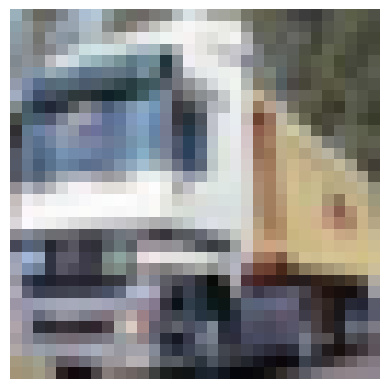

'truck'

In [19]:
idx = 1
X = X_train[idx:idx+1]
show(X)
predict(X)

We will now call our outlier detector directly.

In [20]:
od_preds = outlier(X)

After a few seconds, we can check the event display for an outlier detection prediction. This should be false.

In [21]:
res=!kubectl logs -n cifar10 $(kubectl get pod -n cifar10 -l app=hello-display -o jsonpath='{.items[0].metadata.name}') 
data= []
for i in range(0,len(res)):
    if res[i] == 'Data,':
        data.append(res[i+1])
j = json.loads(json.loads(data[-1]))
print("Outlier",j["data"]["is_outlier"]==[1])

Outlier False


## Outlier Prediction

In [22]:
np.random.seed(0) 
X_mask, mask = apply_mask(X.reshape(1, 32, 32, 3),
                                  mask_size=(10,10),
                                  n_masks=1,
                                  channels=[0,1,2],
                                  mask_type='normal',
                                  noise_distr=(0,1),
                                  clip_rng=(0,1))

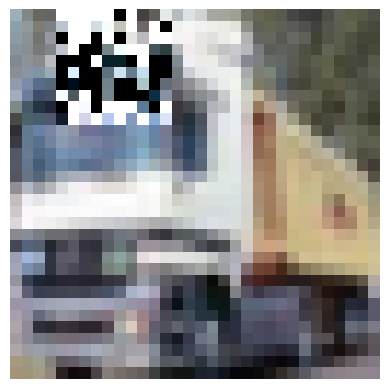

'truck'

In [23]:
show(X_mask)
predict(X_mask)


We will now call our outlier detector directly and use the feature scores returned to gather more information about why it predicted an outlier below.

In [24]:
od_preds = outlier(X_mask)

First, we'll confirm that an outlier was found by checking the event display for a new message.

In [25]:
res=!kubectl logs -n cifar10 $(kubectl get pod -n cifar10 -l app=hello-display -o jsonpath='{.items[0].metadata.name}') 
data= []
for i in range(0,len(res)):
    if res[i] == 'Data,':
        data.append(res[i+1])
j = json.loads(json.loads(data[-1]))
print("Outlier",j["data"]["is_outlier"]==[1])

Outlier True


Now we'll plot the feature scores returned by the outlier detector along with the original image.

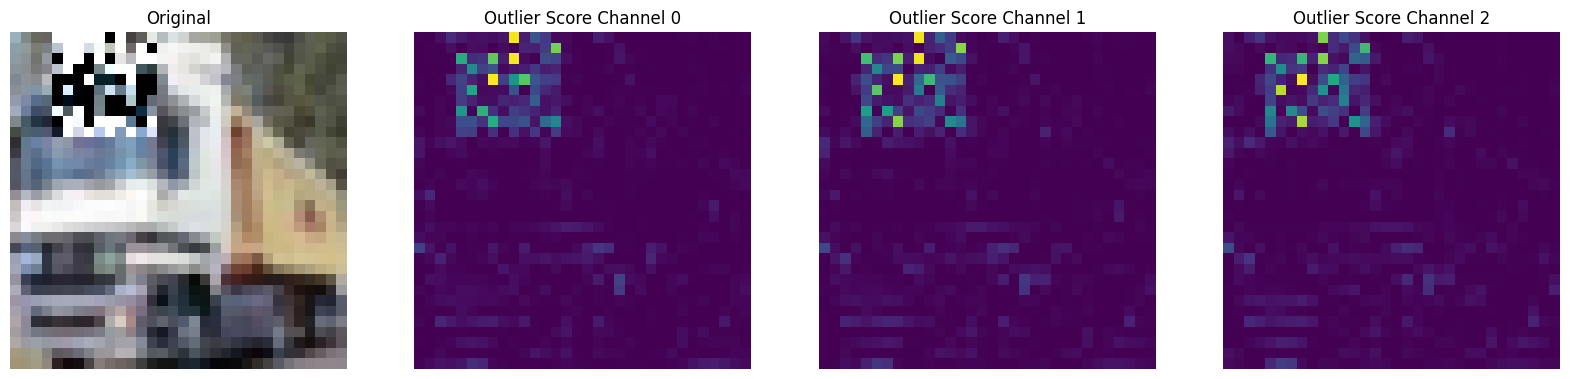

In [26]:
plot_feature_outlier_image(od_preds, 
                           X_mask, 
                           X_recon=None)

## Tear Down

In [ ]:
!kubectl delete ns cifar10